# Cross-Entropy Method

---

In this notebook, we will train the Cross-Entropy Method with OpenAI Gym's MountainCarContinuous environment.

### 1. Import the Necessary Packages

In [1]:
import sys
print("Python %s" % sys.version)
import math
from collections import deque

Python 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [2]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.16.5


In [23]:
import gym
print("OpenAI Gym %s" % gym.__version__)
from gym import wrappers

OpenAI Gym 0.14.0


In [4]:
import matplotlib
print("matplotlib %s" % matplotlib.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib 3.1.1


In [5]:
import torch
print("PyTorch %s" % torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

PyTorch 1.2.0


In [19]:
from IPython import display

### 2. Instantiate the Environment and Agent

In [6]:
env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)
env

<TimeLimit<Continuous_MountainCarEnv<MountainCarContinuous-v0>>>

In [7]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

observation space: Box(2,)
action space: Box(1,)
  - low: [-1.]
  - high: [1.]


In [8]:
class Agent(nn.Module):
    def __init__(self, env, device, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        self.device = device
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(
            weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = self.fc1(x).relu()
        x = self.fc2(x).tanh()
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(self.device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
agent = Agent(env, device).to(device)

In [11]:
agent

Agent(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

### 3. Train the Agent with the Cross-Entropy Method

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

Episode 10	Average Score: -1.44
Episode 20	Average Score: -3.98
Episode 30	Average Score: -4.18
Episode 40	Average Score: 2.57
Episode 50	Average Score: 18.74
Episode 60	Average Score: 29.35
Episode 70	Average Score: 38.69
Episode 80	Average Score: 45.65
Episode 90	Average Score: 47.98
Episode 100	Average Score: 52.56
Episode 110	Average Score: 62.09
Episode 120	Average Score: 72.28
Episode 130	Average Score: 82.21
Episode 140	Average Score: 89.48

Environment solved in 47 iterations!	Average Score: 90.83


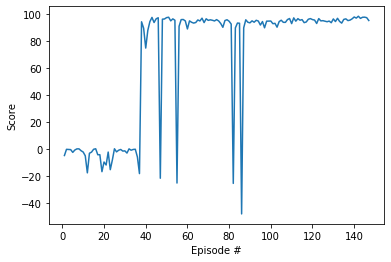

In [12]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, 
        pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) 
                       for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) 
                            for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, 
                                                             np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(
                i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

```
while sleep 0.2; do
nvidia-smi --query-gpu=name,index,temperature.gpu,\
utilization.gpu,utilization.memory,\
memory.total,memory.free,memory.used --format=csv,noheader
done
```

```
GeForce GTX 1060, 0, 60, 9 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 0 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 9 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 0 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 9 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 9 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 9 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 9 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 11 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 9 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 11 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 11 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 13 %, 2 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 11 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
GeForce GTX 1060, 0, 60, 8 %, 1 %, 6078 MiB, 5246 MiB, 832 MiB
```

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [14]:
device = torch.device("cpu")
device

device(type='cpu')

In [15]:
agent = Agent(env, device).to(device)
agent.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

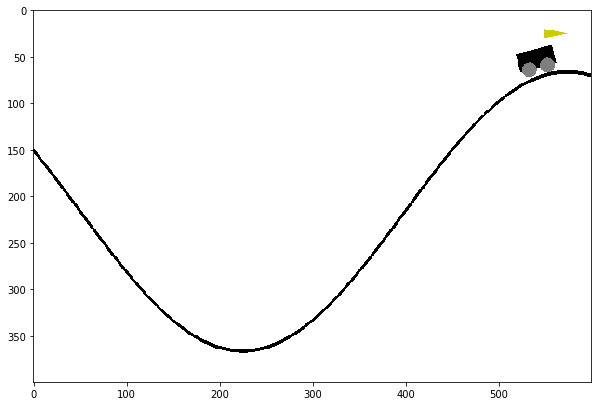

In [36]:
plt.figure(figsize=(10,10))
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
while True:
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

Save video to file.

In [37]:
env = wrappers.Monitor(env, "./gym-results", force=True)
state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

Convert mp4 file to GIF.

In [38]:
%%bash
ls -l ./gym-results

total 116
-rw-r--r-- 1 eka eka    172 Oct  2 23:27 openaigym.episode_batch.2.21965.stats.json
-rw-r--r-- 1 eka eka    238 Oct  2 23:27 openaigym.manifest.2.21965.manifest.json
-rw-r--r-- 1 eka eka   2136 Oct  2 23:27 openaigym.video.2.21965.video000000.meta.json
-rw-r--r-- 1 eka eka 103346 Oct  2 23:27 openaigym.video.2.21965.video000000.mp4


In [39]:
%%bash
ffmpeg -i ./gym-results/openaigym.video.2.21965.video000000.mp4 ./gifs/001.gif

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

## Hardware Specifications and Software Versions

In [30]:
%%bash
cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [31]:
%%bash
nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [33]:
%%bash
nvidia-smi

Wed Oct  2 23:24:59 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8    12W /  N/A |    947MiB /  6078MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [34]:
%%bash
pip freeze

atari-py==0.2.6
attrs==19.1.0
backcall==0.1.0
bleach==3.1.0
box2d-py==2.3.8
certifi==2019.6.16
cffi==1.12.3
cloudpickle==1.2.2
cycler==0.10.0
Cython==0.29.13
decorator==4.4.0
defusedxml==0.6.0
entrypoints==0.3
future==0.17.1
glfw==1.8.3
gym==0.14.0
imageio==2.5.0
ipykernel==5.1.2
ipython==7.8.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.15.1
Jinja2==2.10.1
jsonschema==3.0.2
jupyter==1.0.0
jupyter-client==5.3.1
jupyter-console==6.0.0
jupyter-core==4.5.0
kiwisolver==1.1.0
lockfile==0.12.2
MarkupSafe==1.1.1
matplotlib==3.1.1
mistune==0.8.4
mkl-fft==1.0.14
mkl-random==1.0.2
mkl-service==2.3.0
mujoco-py==2.0.2.5
nbconvert==5.5.0
nbformat==4.4.0
notebook==6.0.1
numpy==1.16.5
olefile==0.46
opencv-python==4.1.1.26
pandocfilters==1.4.2
parso==0.5.1
pexpect==4.7.0
pickleshare==0.7.5
Pillow==6.1.0
prometheus-client==0.7.1
prompt-toolkit==2.0.9
ptyprocess==0.6.0
pycparser==2.19
pyglet==1.3.2
Pygments==2.4.2
pyparsing==2.4.2
pyrsistent==0.14.11
python-dateutil==2.8.0
pytz==2019.2
PyYAML==5.1